In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img, title="", cmap="gray", size=6):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

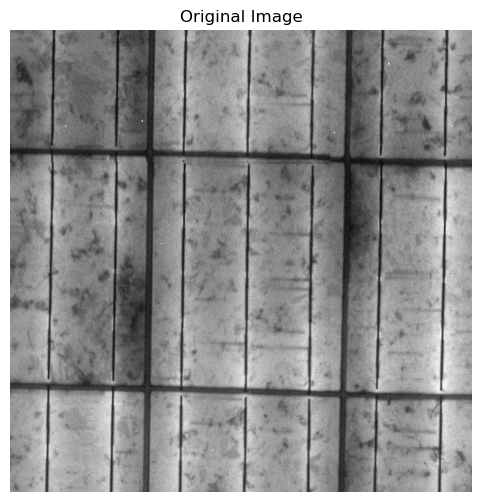

In [3]:
img = cv2.imread("ARTS_00001_r4_c4.png", cv2.IMREAD_GRAYSCALE)
show(img, "Original Image")

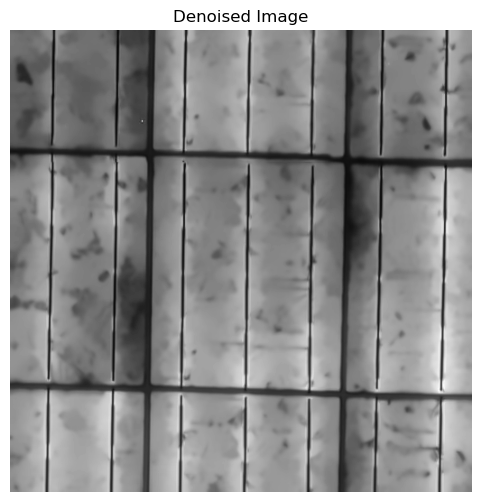

In [4]:
denoised = cv2.fastNlMeansDenoising(img, h=10)
show(denoised, "Denoised Image")

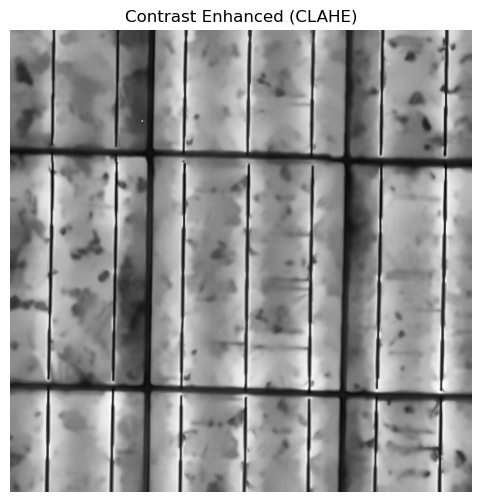

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(denoised)
show(enhanced, "Contrast Enhanced (CLAHE)")

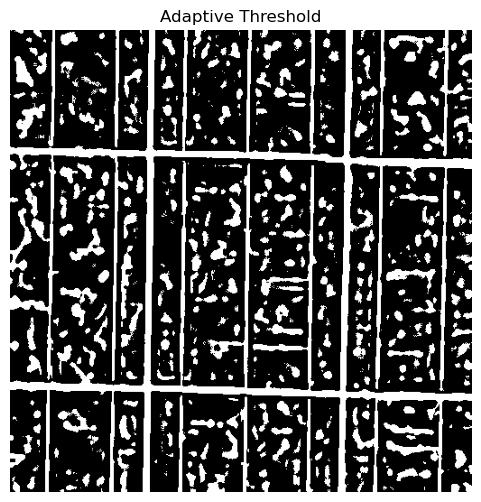

In [6]:
th = cv2.adaptiveThreshold(enhanced, 255,
                           cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV,
                           15, 5)
show(th, "Adaptive Threshold")

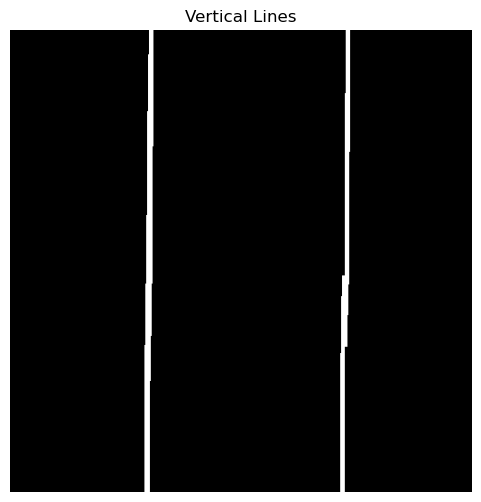

In [24]:
kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (3, img.shape[0]//2))
vert_lines = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_vert)
show(vert_lines, "Vertical Lines")

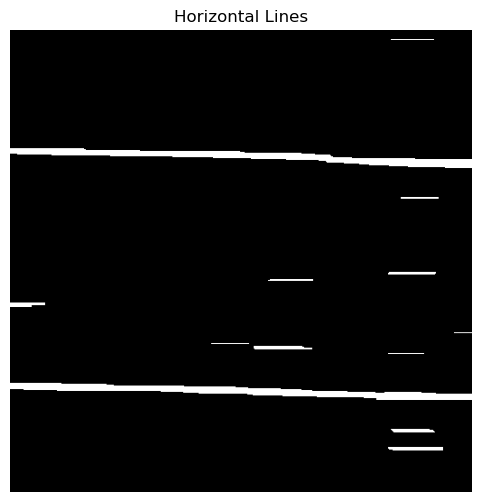

In [25]:
kernel_horz = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
horz_lines = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_horz)
show(horz_lines, "Horizontal Lines")

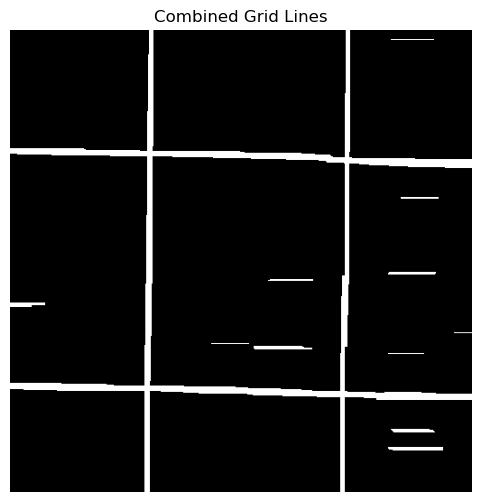

In [26]:
grid = cv2.addWeighted(vert_lines, 1, horz_lines, 1, 0)
show(grid, "Combined Grid Lines")

In [27]:
contours, _ = cv2.findContours(grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key=cv2.contourArea)

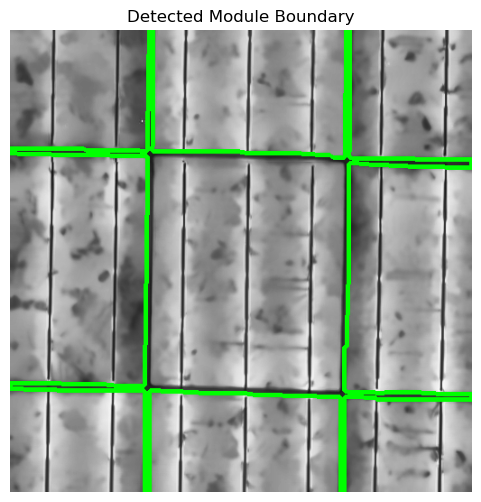

In [28]:
contour_img = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, [cnt], -1, (0, 255, 0), 3)
show(contour_img, "Detected Module Boundary")

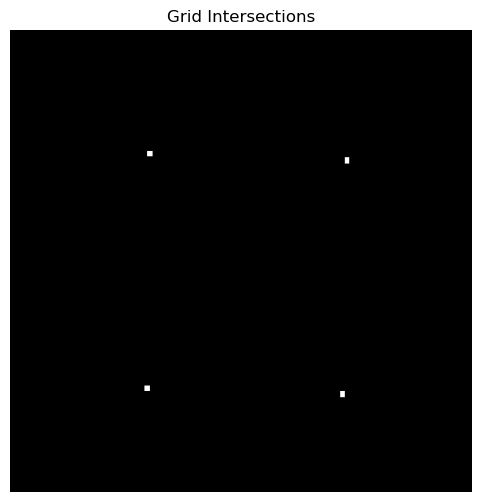

In [29]:
intersections = cv2.bitwise_and(vert_lines, horz_lines)
show(intersections, "Grid Intersections")

In [30]:
coords = cv2.findNonZero(intersections)

In [31]:
points = coords[:,0,:]   # reshape
# Sort by y then x
points = points[np.lexsort((points[:,0], points[:,1]))]
rows = []
row = [points[0]]
for p in points[1:]:
    if abs(p[1] - row[-1][1]) < 10:  # tolerance
        row.append(p)
    else:
        rows.append(row)
        row = [p]
rows.append(row)

# Sort each row by X
for row in rows:
    row.sort(key=lambda x: x[0])


In [32]:
print("Number of intersection rows:", len(rows))
for i, r in enumerate(rows):
    print(f" Row {i}: {len(r)} points")


Number of intersection rows: 2
 Row 0: 71 points
 Row 1: 71 points


In [33]:
# Inspect detected grid
print("Detected intersection rows:", len(rows))
for i, r in enumerate(rows):
    print(f"Row {i}: {len(r)} points")

# Auto-detect module grid size
NUM_INTERSECTION_ROWS = len(rows)
NUM_INTERSECTION_COLS = len(rows[0])

NUM_CELL_ROWS = NUM_INTERSECTION_ROWS - 1
NUM_CELL_COLS = NUM_INTERSECTION_COLS - 1

mid_row = NUM_CELL_ROWS // 2
mid_col = NUM_CELL_COLS // 2

top_left      = rows[mid_row][mid_col]
top_right     = rows[mid_row][mid_col + 1]
bottom_left   = rows[mid_row + 1][mid_col]
bottom_right  = rows[mid_row + 1][mid_col + 1]

src_pts = np.float32([top_left, top_right, bottom_left, bottom_right])
print("src_pts:", src_pts)


Detected intersection rows: 2
Row 0: 71 points
Row 1: 71 points
src_pts: [[157. 139.]
 [371. 141.]
 [154. 399.]
 [366. 400.]]


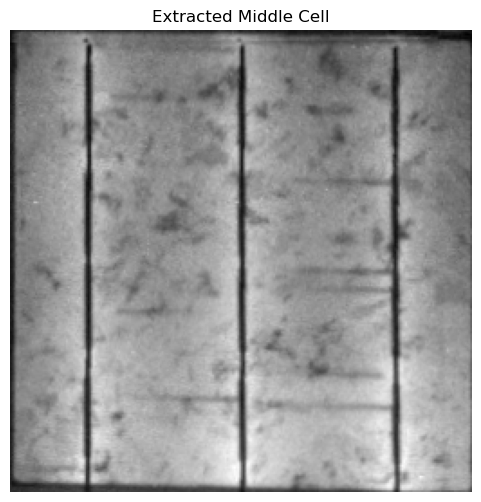

In [34]:
dst_pts = np.float32([
    [0,0],
    [256,0],
    [0,256],
    [256,256]
])
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
cell = cv2.warpPerspective(img, M, (256, 256))
show(cell, "Extracted Middle Cell")
